In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from glob import glob
from sklearn.metrics import classification_report

In [26]:
test_data_sizes = {
    "bcsstk18": 1000,
    "cbuckle": 1000,
    "ct20stif": 1000,
    "raefsky4": 1000,
    "vanbody": 100
}

matrix = "vanbody"
df = pd.read_csv(f"data/{matrix}_{test_data_sizes[matrix]}.csv")
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,vanbody.mat,491,0.000001,49100,35528,74,49099,1.915060e-05,False,246.083343,1.511085e+05,47072,99.997963
1,vanbody.mat,491,0.000001,49100,37556,139,49099,4.618660e-06,False,246.444212,3.650676e+05,47072,99.997963
2,vanbody.mat,491,0.000001,49100,38358,193,49099,3.148359e-05,False,246.087799,8.792099e+05,47072,99.997963
3,vanbody.mat,491,0.000001,49100,46845,122,49099,6.786779e-05,False,246.800207,5.503797e+06,47072,99.997963
4,vanbody.mat,491,0.000001,49100,11088,312,32222,9.504907e-07,True,162.786341,7.860428e+04,47072,65.625255


In [27]:
df.sort_values("slowdown", inplace=False, ascending=False).head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,vanbody.mat,491,0.000001,49100,35528,74,49099,0.000019,False,246.083343,1.511085e+05,47072,99.997963
45,vanbody.mat,491,0.000001,49100,4753,435,49099,0.000006,False,243.436424,1.262481e+07,47072,99.997963
70,vanbody.mat,491,0.000001,49100,14202,9,49099,0.000704,False,242.352364,1.427001e+07,47072,99.997963
69,vanbody.mat,491,0.000001,49100,4460,407,49099,0.000005,False,242.556398,1.072461e+07,47072,99.997963
68,vanbody.mat,491,0.000001,49100,14884,242,49099,0.000013,False,242.489300,1.262916e+05,47072,99.997963


In [28]:
X_test = df[["error_iter", "pos_2norm"]].to_numpy()
y_test = df["slowdown"].to_numpy()

In [29]:
p = 1 / 98
1 + (1 / p)

# 1 + (1 / x) = 99
# (1 / x) = 98
# x = 1 / 98

99.00000000000001

In [30]:
models = [load(fn) for fn in glob(f"./models/{matrix}/*.pkl")]
model_names = [model.steps[-1][1].__class__.__name__ for model in models]
ps = list(np.arange(1 / 98, 1, 0.01))

reports = pd.DataFrame(index=ps, columns=model_names)
reports.head()

,Ridge,RandomForestRegressor,KNeighborsRegressor,XGBRegressor,LinearSVR
0.010204,NaN,NaN,NaN,NaN,NaN
0.020204,NaN,NaN,NaN,NaN,NaN
0.030204,NaN,NaN,NaN,NaN,NaN
0.040204,NaN,NaN,NaN,NaN,NaN
0.050204,NaN,NaN,NaN,NaN,NaN


In [31]:
for p in ps:
    for model, name in zip(models, model_names):
        preds = model.predict(X_test)
        y_pred_clas = preds > (1 + (1 / p))
        y_true_clas = y_test > (1 + (1 / p))
        reports.loc[p][name] = classification_report(y_true_clas, y_pred_clas, 
                                                     zero_division=0, output_dict=True)

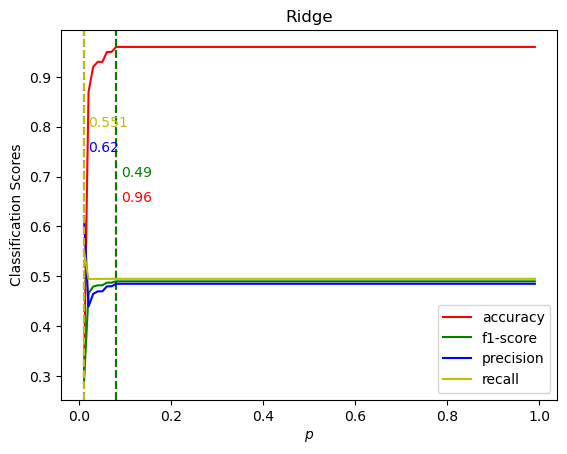

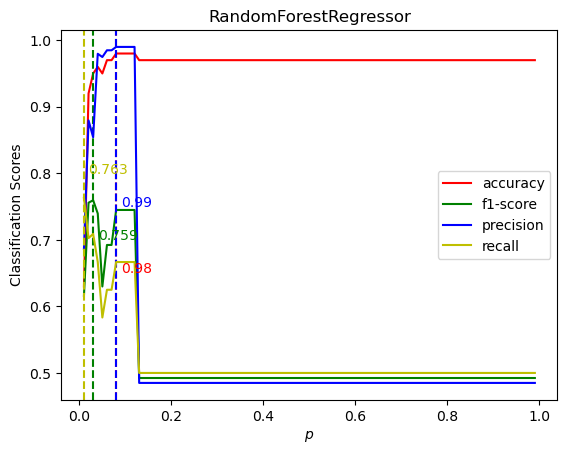

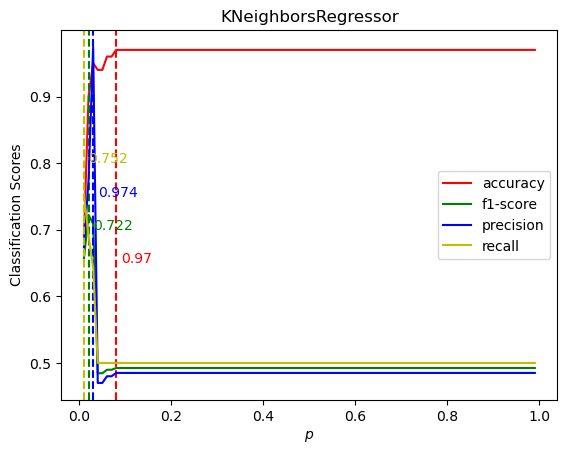

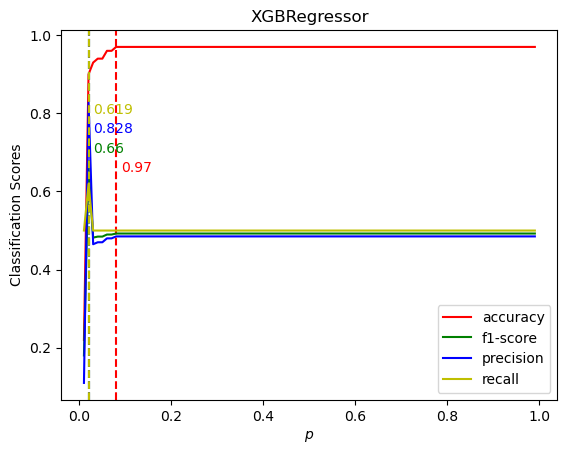

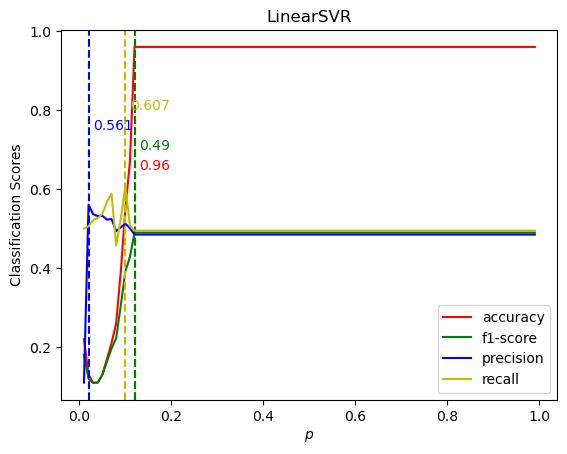

In [34]:
for name, series in reports.items():
    accuracies = [item["accuracy"] for item in series]
    best_acc_p = ps[np.argmax(accuracies)]
    scores = [item["macro avg"] for item in series]
    f1_scores = [score["f1-score"] for score in scores]
    best_f1_p = ps[np.argmax(f1_scores)]
    precisions = [score["precision"] for score in scores]
    best_precision_p = ps[np.argmax(precisions)]
    recalls = [score["recall"] for score in scores]
    best_recall_p = ps[np.argmax(recalls)]

    plt.plot(ps, accuracies, label=f"accuracy", c="r")
    plt.axvline(x=best_acc_p, linestyle='--', c="r")
    plt.annotate(f"{round(np.max(accuracies), 3)}", xy=(best_acc_p + 0.01, 0.65), c="r")

    plt.plot(ps, f1_scores, label=f"f1-score", c="g")
    plt.axvline(x=best_f1_p, linestyle='--', c="g")
    plt.annotate(f"{round(np.max(f1_scores), 3)}", xy=(best_f1_p + 0.01, 0.7), c="g")

    plt.plot(ps, precisions, label=f"precision", c="b")
    plt.axvline(x=best_precision_p, linestyle='--', c="b")
    plt.annotate(f"{round(np.max(precisions), 3)}", xy=(best_precision_p + 0.01, 0.75), c="b")

    plt.plot(ps, recalls, label=f"recall", c="y")
    plt.axvline(x=best_recall_p, linestyle='--', c="y")
    plt.annotate(f"{round(np.max(recalls), 3)}", xy=(best_recall_p + 0.01, 0.8), c="y")

    plt.title(name)
    plt.xlabel("$p$")
    plt.ylabel("Classification Scores")
    plt.legend()
    os.makedirs(f"./figures/{matrix}", exist_ok=True)
    plt.savefig(f"./figures/{matrix}/{name}.png")
    plt.show()